In [10]:
import os, sys, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from random import randint
from image_processing_tools import *
import imageio
import imgaug as ia
%matplotlib inline

def append_id(filename, i):
    return "{0}_{2}.{1}".format(*filename.rsplit('.', 1) + [i])

In [11]:
excluded = set([".mayaSwatches", ".ipynb_checkpoints", "unprocessed", "cyan", "red", "scaled", "augmented"])
names = []
res = 112

def update_progress(count, total, status=''):
    bar_len = 20
    filled_len = int(round(bar_len * count / float(total)))
    percents = round(100.0 * count / float(total), 1)
    bar = '=' * filled_len + '-' * (bar_len - filled_len)
    # As suggested by Rom Ruben (see: http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console/27871113#comment50529068_27871113)
    sys.stdout.write('[%s] %s%s ...%s\r' % (bar, percents, '%', status))
    sys.stdout.flush()


### Extract Images from PDF Library

In [ ]:
excluded = [".ipynb_checkpoints", "unprocessed"]
extraction_progress = 1
make_png = False
names = []
for path, subdirs, files, in os.walk(pdf_directory):
    for file in files:
        try:
            names.append(file.split('.')[0])
            file_path = os.path.join(path,file)
            new_performer_data(base_name(file_path))
            ##split pdf file into pages
            if (make_png):
                pages = convert_from_path(file_path)
                page_num = 0
                for page in pages:
                    page.save(img_directory + base_name(file_path) + "/unprocessed/" + str(page_num) + ".png", 'PNG')
                    page_num += 1
                    extraction_progress = update_progress(extraction_progress, len(pages)*len(files), "extracting images from pdf files")
                page_num = 0
        except Exception as e:
            print (e)
            pass
print("extraction complete")

### Crop images around human figure & extract colour channels

In [33]:
# list of colour boundaries
boundaries = [
	([70, 0, 100, 0], [100, 255,255, 255]),
	([0, 50, 0, 0], [70, 255,255, 255])
]

for path, subdirs, files, in os.walk(img_directory):
    for subdir in [s for s in subdirs if s not in excluded]:
        names.append(subdir)
        print("Reading from foler: " + subdir)
        for path, subdirs, files, in os.walk(img_directory+subdir+"/unprocessed"):
            for file in files:
                drawings = []
                file_path = os.path.join(path,file)
                img = cv2.imread(file_path)
                #fill space around manikin, in top-left corner and top
                img = add_whitespace(img, 0, 0, 700, 450)
                img = add_whitespace(img, 0, 0, img.shape[0],200)
                #crop around manikin
                cropped_img = crop_heatmap(img, 0)
                file_path = os.path.join(os.path.normpath(os.path.join(path, os.pardir)),file)
                cv2.imwrite(file_path, cropped_img)
                ## convert to hsv
                hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)
                # loop over the boundaries
                for lower_bound, upper_bound in boundaries:
                    drawings.append(extract_drawing(cropped_img, hsv, tuple(lower_bound), tuple(upper_bound)))
                ## separate masking of cyan and red + ## filter bodily outline
                file_path = os.path.normpath(os.path.join(file_path, os.pardir))
                cyan_drawing, red_drawing = drawings
                cv2.imwrite(file_path+"/cyan/scaled/"+file, compress(cyan_drawing, (res, res)))
                cv2.imwrite(file_path+"/red/scaled/"+file, compress(red_drawing, (res, res)))                

Reading from foler: Outi
Reading from foler: Zjana
Reading from foler: Simona
Reading from foler: Juan
Reading from foler: Ella
Reading from foler: Eleonora
Reading from foler: Hanna
Reading from foler: Einav
Reading from foler: Kadri
Reading from foler: Sylvia


### Augment image collection by colour channel

In [12]:
def get_seqs():
    seq = []
    # Geometric distortion effect
    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=90, sigma=4), 
    ], random_order=True))

    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=120, sigma=4),
    ], random_order=True))

    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=90, sigma=2), 
    ], random_order=True))

    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=120, sigma=2),
    ], random_order=True))
    
    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=100, sigma=0.9),
    ], random_order=True))
    
    ## added blur
    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=100, sigma=3),
        iaa.MotionBlur(44, randint(30, 360), 1.0, 0),
    ], random_order=True))

    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=120, sigma=3),
        iaa.MotionBlur(66, randint(30, 360), 1.0, 0),
    ], random_order=False))

    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=100, sigma=1.5),
        iaa.MotionBlur(44, randint(30, 360), 1.0, 0),
    ], random_order=False))

    seq.append(iaa.Sequential([
        iaa.ElasticTransformation(alpha=120, sigma=0.7),
        iaa.MotionBlur(66, randint(30, 360), 1.0, 0),
    ], random_order=False))
    return seq


Reading from foler: Zjana


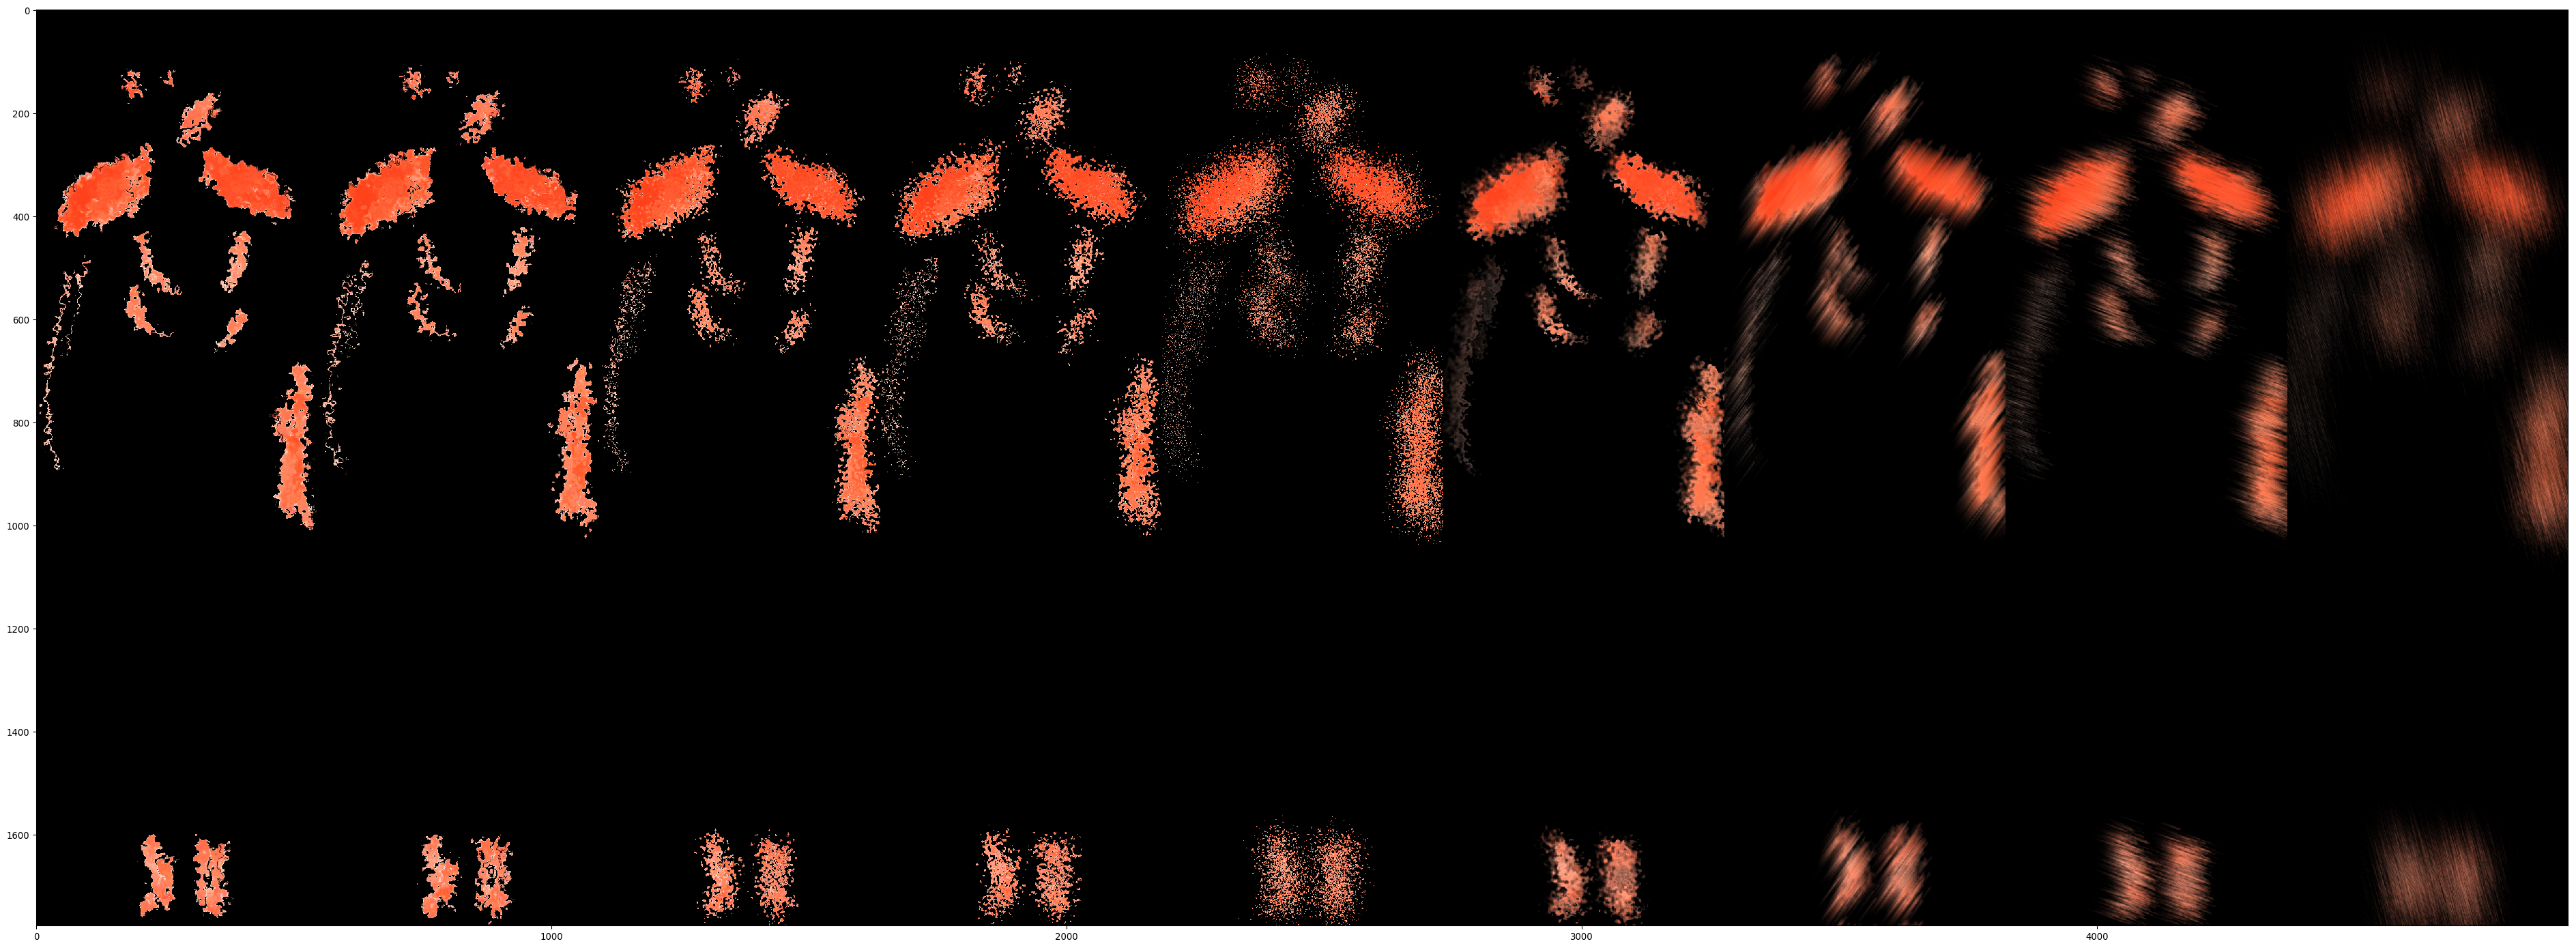

KeyboardInterrupt: 

In [18]:
excluded = set([".mayaSwatches", ".ipynb_checkpoints", "unprocessed", "cyan", "red", "scaled", "augmented"])
# list of colour boundaries
boundaries = [
	([70, 0, 100, 0], [100, 255,255, 255]),
	([0, 50, 0, 0], [70, 255,255, 255])
]

augmented_images = None
count = 0

for path, subdirs, files, in os.walk(img_directory, topdown=True):
    for subdir in [s for s in subdirs if s not in excluded]:
        print("\nReading from foler: " + subdir)
        for file in os.listdir(img_directory+subdir):
            if file.endswith(".png"):
                file_path = os.path.join(img_directory+subdir+"/red/",file)
                cropped_img = imageio.imread(file_path)
                ## generate variations of image
                augmented_images = generate_augmentation(cropped_img, get_seqs())
                file_path = os.path.normpath(os.path.join(file_path, os.pardir))
                for idx in range(len(augmented_images)):
                    augmented_im = augmented_images[idx]
                    uri = append_id(file_path+"/augmented/"+file, idx)
                    imageio.imwrite(append_id(file_path+"/augmented/"+file, idx), compress(augmented_im, (res, res)))
                file_path = os.path.join(img_directory+subdir+"/cyan/",file)
                cropped_img = imageio.imread(file_path)
                ## generate variations of image
                augmented_images = generate_augmentation(cropped_img, get_seqs())
                file_path = os.path.normpath(os.path.join(file_path, os.pardir))
                for idx in range(len(augmented_images)):
                    augmented_im = augmented_images[idx]
                    uri = append_id(file_path+"/augmented/"+file, idx)
                    imageio.imwrite(append_id(file_path+"/augmented/"+file, idx), compress(augmented_im, (res, res)))
                count = count + 1
                update_progress(count, 10, "")
        count = 0

# for i in range(np.shape(im)[0]):  
#     ia.imshow(np.hstack(im[i]))

In [ ]:
images = [cv2.imread(file) for file in glob.glob('data/img/Juan/*png')]
for img in images:
    tmp = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(img)
    rgba = [b,g,r, alpha]
    dst = cv2.merge(rgba,4)
    cv2.imwrite("test.png", dst)

In [ ]:
drawings = drawings[:5]
# augment them as one batch
images_aug = []
for i in range(len(drawings)):
    images_aug = []
    for j in range(len(seq)):
        images_aug.append(seq[j].augment_images(drawings))
images_aug = np.array(images_aug)
images_aug = images_aug.transpose()
print(np.shape(images_aug))

In [ ]:
filelist=glob.glob("sketch_dataset/*.png")
for file in filelist:
    os.remove(file)

In [ ]:
from imutils import paths
def create_gif(inputPath, outputPath, delay, finalDelay, loop):
    # grab all image paths in the input directory
    imagePaths = sorted(list(paths.list_images(inputPath)))
    print(imagePaths)

    # remove the last image path in the list
    lastPath = imagePaths[-1]
    imagePaths = imagePaths[:-1]

    # construct the image magick 'convert' command that will be used
    # generate our output GIF, giving a larger delay to the final
    # frame (if so desired)
    cmd = "convert -delay {} {} -delay {} {} -loop {} {}".format(
        delay, " ".join(imagePaths), finalDelay, lastPath, loop,
        outputPath)
    os.system(cmd)

create_gif("../output/tests/result3", "../output/new.gif", 0, 0, 0)

In [28]:
from time import sleep
lat_space = np.random.rand(1, 64)
noise = np.random.normal(0,0.01,64)
while 1:
    lat_space = numpy.add(lat_space, noise)
    print(lat_space)
    sleep(1)

[[0.73763127 0.85867266 0.51512893 0.44287209 0.39858194 0.66799768
  0.93438549 0.59590417 0.82682479 0.82378402 0.97508078 0.25411254
  0.55522038 0.92192126 0.71603677 0.52211709 0.32508702 0.98850171
  0.60958541 0.3361495  0.65949249 0.72382998 0.0620352  0.74958743
  0.67004079 0.11579191 0.23410546 0.87806106 0.54032903 0.53228386
  0.90809653 0.61313432 0.74359926 0.86641524 0.23739882 0.66758486
  0.47457284 0.813263   0.76840795 0.90922859 0.77165332 0.27806101
  0.20115522 0.20489238 0.99686797 0.96101099 0.82488799 0.14322341
  0.69966384 0.54181728 0.53016455 0.79154469 0.04822745 0.16248231
  0.75795363 0.21910284 0.70624383 0.92158124 0.02830612 0.78755669
  0.73489162 0.36200713 0.76881268 0.36922407]]
[[0.73948868 0.83622363 0.51166218 0.42852042 0.38932282 0.66775964
  0.92668459 0.60181614 0.83551763 0.82956326 0.96366157 0.24593855
  0.55617098 0.91907522 0.73181983 0.51268568 0.32617921 0.97940738
  0.61576388 0.33273837 0.64976242 0.73250332 0.05836743 0.73848537


KeyboardInterrupt: 